In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast
import math
import scipy.stats as stats
import preprocessing_helper

import statsmodels.formula.api as smf

In [10]:
path_lda_romance = './Data/LDA/GENRES/'

characters_all = pd.read_csv('./Data/Preprocessed/preprocessed_characters.tsv', delimiter='\t')
characters_romance = pd.read_csv('./Data/Preprocessed/preprocessed_characters_romance.tsv', delimiter='\t')
summaries = pd.read_csv('./Data/MovieSummaries/plot_summaries.txt', sep="\t", names=['movie_id', 'summary'])
movies = pd.read_csv('./Data/Preprocessed/movie.metadata.augmented.tsv', delimiter='\t')

movies['genres'] = movies['genres'].apply(lambda genre : ast.literal_eval(genre))
movies['languages'] = movies['languages'].apply(lambda language : ast.literal_eval(language))
movies['countries'] = movies['countries'].apply(lambda countries : ast.literal_eval(countries))

In [8]:
def normalize(data):
    return data/np.sum(data)

def top_n_indices(data, n):
    ind = np.argpartition(data, -n)[-n:]
    ind = ind[np.argsort(data[ind])][::-1]
    return ind

In [17]:
TOP_N_WORDS = 10
NB_TOPICS = 50
topics = np.ones((NB_TOPICS,1000))

with open(path_lda_romance +'lda.topics.tsv') as f:
    vocabulary = np.array(f.readline().split())
    i = 0
    
    for line in f:
        topics[i] = np.array(line.split(), dtype=float)
        i += 1

i=0
ind = np.argpartition(topics[i], -TOP_N_WORDS)[-TOP_N_WORDS:]
print('------------------\nThe top '+ str(TOP_N_WORDS) + ' words in topic ' + str(i) + ' are :') 
for index in top_n_indices(topics[i], TOP_N_WORDS) : 
    print(vocabulary[index], int(topics[i][index]))

------------------
The top 10 words in topic 0 are :
son 26212
able 12323
dead 10575
detective 9976
director 9896
alive 9079
former 8777
agent 7109
suspicious 7054
about 7036


In [14]:
agents = np.ones((NB_TOPICS,NB_TOPICS))
patients = np.ones((NB_TOPICS,NB_TOPICS))
modifiee = np.ones((NB_TOPICS,NB_TOPICS))

with open(path_lda_romance +'personas.tsv') as f:
    i = 0
    for line in f:
        # extracts the probabilities for each persona
        data = np.array(line.split('\t')[1].split(), dtype=float)
        agents[i] = normalize(data[:NB_TOPICS])
        patients[i] = normalize(data[NB_TOPICS:2*NB_TOPICS])
        modifiee[i] = normalize(data[2*NB_TOPICS:])
        
        i += 1

In [15]:
def describe_persona(persona, topic_number=4):
    fig = plt.figure(figsize=(10, 2))

    plt.subplot(131)
    plt.title('Agents')
    plt.plot(agents[persona])

    plt.subplot(132)
    plt.title('Patients')
    plt.plot(patients[persona])

    plt.subplot(133)
    plt.title('Modifiee')
    plt.plot(modifiee[persona])

    fig.tight_layout()
    plt.show()

    top_agents_topics = top_n_indices(agents[persona], topic_number)
    top_patients_topics = top_n_indices(patients[persona], topic_number)
    top_modifiee_topics = top_n_indices(modifiee[persona], topic_number)

    print(f"The most important agent topics for persona {persona} are : ")
    for t in top_agents_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocabulary[top_words]))
        
    print('\n-------------------')
    print(f"The most important patient topics for persona {persona} are : ")
    for t in top_patients_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocabulary[top_words]))

    print('\n-------------------')
    print(f"The most important modifiee topics for persona {persona} are : ")
    for t in top_modifiee_topics : 
        top_words = top_n_indices(topics[t], 10)
        print('topic ' + str(t) + ' : ' + str(vocabulary[top_words]))

In [18]:
characters_genres = characters_romance.merge(movies[['movie_id', 'genres', 'movie_name']], on='movie_id', how='left')

exploded = characters_genres.explode('genres') # obtain all the possible genres
pivot = exploded.groupby(['persona', 'genres']).size().reset_index(name='Count')
# pivot so we have genres as columns
pivot = pivot.pivot(index='persona', columns='genres', values='Count').fillna(0)
# normalize the values per column (genre) se we have values between 0 and 1
normalized = pivot.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)

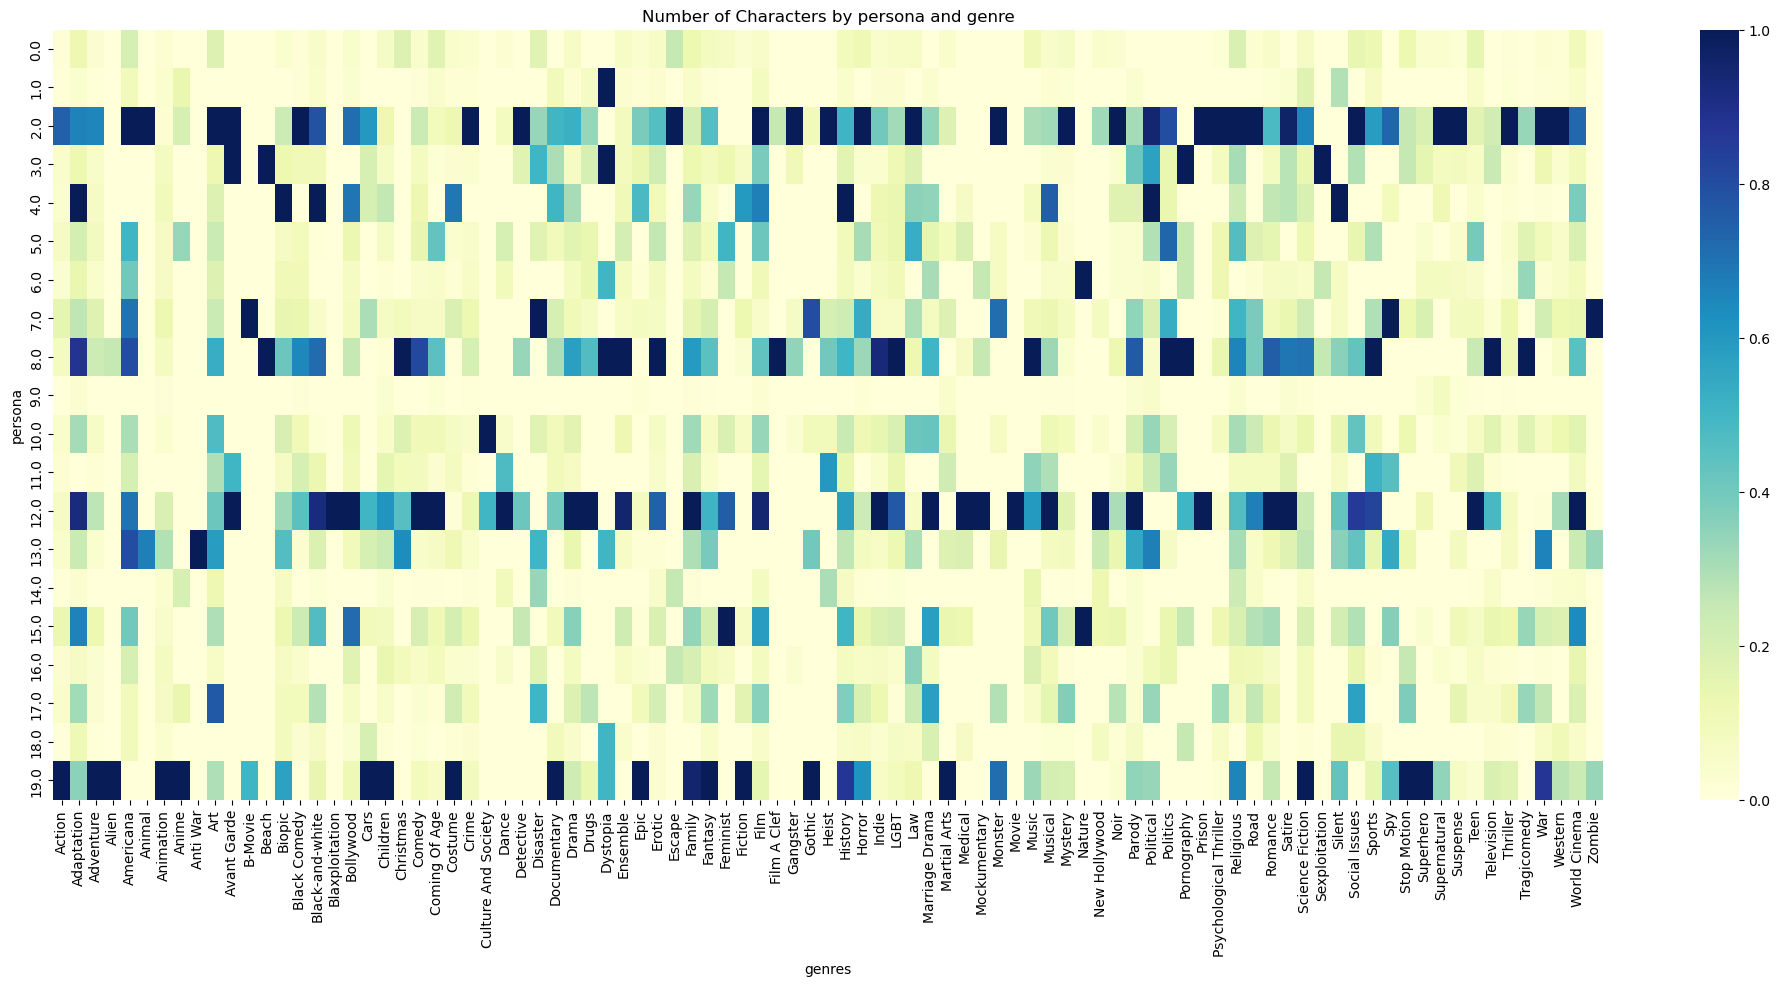

In [19]:
plt.figure(figsize=(25, 10))
sns.heatmap(normalized, annot=False, cmap='YlGnBu', fmt='g')
plt.title('Number of Characters by persona and genre')
plt.show()

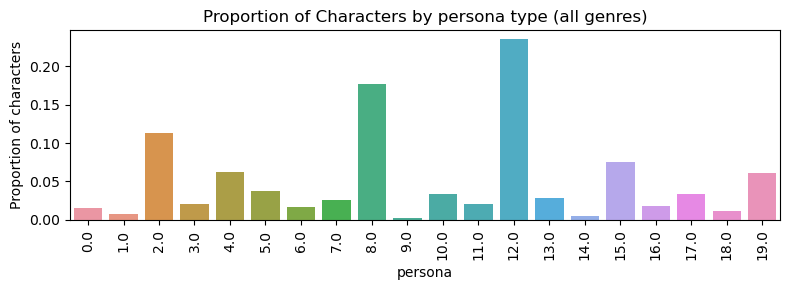

In [20]:
persona_count = characters_genres.groupby('persona').size().reset_index(name='Count')
persona_total = persona_count['Count'].sum()
persona_count['Proportion'] = persona_count['Count'].apply(lambda x: x/persona_total)

plt.figure(figsize=(8, 3))
sns.barplot(data=persona_count, x='persona', y='Proportion', errorbar=None)
plt.title('Proportion of Characters by persona type (all genres)')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks
plt.ylabel('Proportion of characters')
plt.tight_layout()
plt.show()

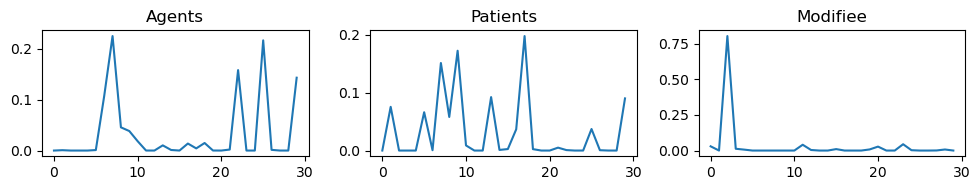

The most important agent topics for persona 9 are : 
topic 7 : ['leave' 'take' 'see' 'be' 'find' 'run' 'have' 'know' 'make' 'look']
topic 25 : ['have' 'meet' 'decide' 'be' 'try' 'begin' 'want' 'find' 'realize' 'get']
topic 22 : ['find' 'try' 'fall' 'manage' 'arrive' 'discover' 'attempt' 'refuse' 'die'
 'learn']
topic 29 : ['go' 'meet' 'return' 'come' 'live' 'arrive' 'join' 'stay' 'work' 'visit']
topic 6 : ['tell' 'go' 'ask' 'say' 'love' 'want' 'give' 'get' 'come' 'walk']
topic 8 : ['get' 'make' 'break' 'introduce' 'go' 'propose' 'end' 'spend' 'sleep'
 'pick']

-------------------
The most important patient topics for persona 9 are : 
topic 17 : ['have' 'live' 'visit' 'raise' 'name' 'care' 'leave' 'kill' 'move'
 'reconcile']
topic 9 : ['give' 'take' 'reveal' 'show' 'convince' 'offer' 'help' 'inform' 'keep'
 'hire']
topic 7 : ['leave' 'take' 'see' 'be' 'find' 'run' 'have' 'know' 'make' 'look']
topic 13 : ['marry' 'meet' 'fall' 'attract' 'send' 'name' 'engage' 'involve'
 'reunite' 'find']

In [22]:
describe_persona(9, 6)